In [1]:
import h5py

filename_hdf = 'greenbeans.h5'

def h5_tree(val, pre=''):
    items = len(val)
    for key, val in val.items():
        items -= 1
        if items == 0:
            # the last item
            if type(val) == h5py._hl.group.Group:
                print(pre + '└── ' + key)
                h5_tree(val, pre+'    ')
            else:
                try:
                    print(pre + '└── ' + key + ' (%d)' % len(val))
                except TypeError:
                    print(pre + '└── ' + key + ' (scalar)')
        else:
            if type(val) == h5py._hl.group.Group:
                print(pre + '├── ' + key)
                h5_tree(val, pre+'│   ')
            else:
                try:
                    print(pre + '├── ' + key + ' (%d)' % len(val))
                except TypeError:
                    print(pre + '├── ' + key + ' (scalar)')

with h5py.File(filename_hdf, 'r') as hf:
    print(hf)
    h5_tree(hf)

<HDF5 file "greenbeans.h5" (mode r)>
├── algo
│   ├── key (scalar)
│   └── processor_config (scalar)
├── client_info (scalar)
├── generation (scalar)
├── lib_version (scalar)
├── server_info (scalar)
├── session
│   ├── calibrations
│   │   └── sensor_1
│   │       ├── data (scalar)
│   │       ├── provided (scalar)
│   │       └── temperature (scalar)
│   ├── group_0
│   │   └── entry_0
│   │       ├── metadata (scalar)
│   │       ├── result
│   │       │   ├── calibration_needed (65763)
│   │       │   ├── data_saturated (65763)
│   │       │   ├── frame (65763)
│   │       │   ├── frame_delayed (65763)
│   │       │   ├── temperature (65763)
│   │       │   └── tick (65763)
│   │       └── sensor_id (scalar)
│   └── session_config (scalar)
├── sessions
│   └── session_0
│       ├── calibrations
│       │   └── sensor_1
│       │       ├── data (scalar)
│       │       ├── provided (scalar)
│       │       └── temperature (scalar)
│       ├── group_0
│       │   └── entry_0
│       

In [2]:
import h5py
import numpy as np

def extract_tensor_from_h5(file_path, dataset_path):
    """
    Extracts a tensor from an H5 file and checks for non-numerical data.

    Parameters:
    - file_path: str, path to the H5 file
    - dataset_path: str, path to the dataset within the H5 file

    Returns:
    - tensor: numpy.ndarray, the extracted tensor if purely numerical
    """
    with h5py.File(file_path, 'r') as h5file:
        if dataset_path in h5file:
            dataset = h5file[dataset_path]
            tensor = np.array(dataset)

            return tensor
        else:
            raise KeyError(f"Dataset {dataset_path} not found in the file {file_path}")


# Example usage
file_path = 'greenbeans.h5'
dataset_path = 'session/group_0/entry_0/result/frame'
tensor = extract_tensor_from_h5(file_path, dataset_path)

# Print the shape of the tensor
print(tensor.shape)


(65763, 1, 64)


In [3]:
import numpy as np

def load_and_convert_tensor(file_path, dataset_path):
    # Extract tensor from HDF5 file
    tensor = extract_tensor_from_h5(file_path, dataset_path)

    # Convert to complex number
    complex_tensor = tensor['real'] + 1j * tensor['imag']

    return complex_tensor

# Load and convert tensors
colombian458tensor = load_and_convert_tensor("colombia458.h5", dataset_path)
kenya458tensor = load_and_convert_tensor("kenya458.h5", dataset_path)
peru458tensor = load_and_convert_tensor("peru458.h5", dataset_path)
sumatra458tensor = load_and_convert_tensor("sumatra458.h5", dataset_path)
tabi458tensor = load_and_convert_tensor("tabilaroca458.h5", dataset_path)
roasted458tensor = load_and_convert_tensor("458roastedbeans.h5", dataset_path)

# def preprocess_data(complex_tensor):
#     # Separate real and imaginary parts
#     real_part = complex_tensor.real.astype(np.float32)
#     imag_part = complex_tensor.imag.astype(np.float32)

#     # Combine into a single input array (concatenation along the last axis)
#     combined_input = np.concatenate([real_part, imag_part], axis=-1)

#     return combined_input

def preprocess_data(complex_tensor):
    # Compute magnitude and phase
    magnitude = np.abs(complex_tensor).astype(np.float32)
    phase = np.angle(complex_tensor).astype(np.float32)

    # Combine into a single input array (concatenation along the last axis)
    combined_input = np.concatenate([magnitude, phase], axis=-1)

    return combined_input

colombian_input = preprocess_data(colombian458tensor)
kenya_input = preprocess_data(kenya458tensor)
peru_input = preprocess_data(peru458tensor)
sumatra_input = preprocess_data(sumatra458tensor)
tabi_input = preprocess_data(tabi458tensor)
roasted_input = preprocess_data(roasted458tensor)

In [4]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Input
from sklearn.model_selection import train_test_split

# Create labels
colombian_labels = np.full(colombian_input.shape[0], 0, dtype=np.int32)
kenya_labels = np.full(kenya_input.shape[0], 1, dtype=np.int32)
peru_labels = np.full(peru_input.shape[0], 2, dtype=np.int32)
sumatra_labels = np.full(sumatra_input.shape[0], 3, dtype=np.int32)
tabi_labels = np.full(tabi_input.shape[0], 4, dtype=np.int32)
roasted_labels = np.full(roasted_input.shape[0], 5, dtype=np.int32)

def squeeze_data(data):
    # Remove dimensions of size 1
    return np.squeeze(data, axis=1)

# Apply squeezing to each tensor
colombian_input = squeeze_data(colombian_input)
kenya_input = squeeze_data(kenya_input)
peru_input = squeeze_data(peru_input)
sumatra_input = squeeze_data(sumatra_input)
tabi_input = squeeze_data(tabi_input)
roasted_input = squeeze_data(roasted_input)

# Combine the squeezed data
all_inputs = np.concatenate([colombian_input, kenya_input, peru_input, sumatra_input, tabi_input, roasted_input], axis=0)
all_labels = np.concatenate([colombian_labels, kenya_labels, peru_labels, sumatra_labels, tabi_labels, roasted_labels], axis=0)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_inputs, all_labels, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# Define the Keras model
input_shape = (64 * 2,)  # Assuming real and imaginary parts are concatenated
model = Sequential([
    Input(shape=input_shape),
    Dense(32, activation='relu'),
    Dense(6, activation='softmax')  # don't forget to change this to the number of classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

2024-08-08 16:42:41.025084: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-08 16:42:41.039155: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-08 16:42:41.042723: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-08 16:42:41.053510: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-08 16:42:41.880138: W tensorflow/compiler/tf2

Training data shape: (477384, 128)
Testing data shape: (119347, 128)


I0000 00:00:1723160563.471292 1291249 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723160563.503141 1291249 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723160563.503272 1291249 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723160563.505635 1291249 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723160563.505714 1291249 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Epoch 1/10


I0000 00:00:1723160564.966877 1291445 service.cc:146] XLA service 0x7fb3b000a130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723160564.966939 1291445 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 SUPER, Compute Capability 8.9
2024-08-08 16:42:44.984545: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-08 16:42:45.066200: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  75/3730 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.3491 - loss: 1999.9781  

I0000 00:00:1723160566.223434 1291445 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3730/3730 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.7460 - loss: 163.5358 - val_accuracy: 0.8481 - val_loss: 15.0192
Epoch 2/10
3730/3730 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8490 - loss: 14.9786 - val_accuracy: 0.8788 - val_loss: 8.1410
Epoch 3/10
3730/3730 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8670 - loss: 8.6008 - val_accuracy: 0.8787 - val_loss: 5.2029
Epoch 4/10
3730/3730 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8764 - loss: 5.0569 - val_accuracy: 0.8876 - val_loss: 2.2817
Epoch 5/10
3730/3730 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8774 - loss: 2.7922 - val_accuracy: 0.8532 - val_loss: 1.7532
Epoch 6/10
3730/3730 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8780 - loss: 1.0364 - val_accuracy: 0.8658 - val_loss: 0.4493
Epoch 7/10
3730/3730 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8720 - loss: 0.3732 - val_accuracy: 0.8723 - val_loss: 0.3558
Epoch 8/10
3730/3730 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8691 - loss: 0.3772 -

3730/3730 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


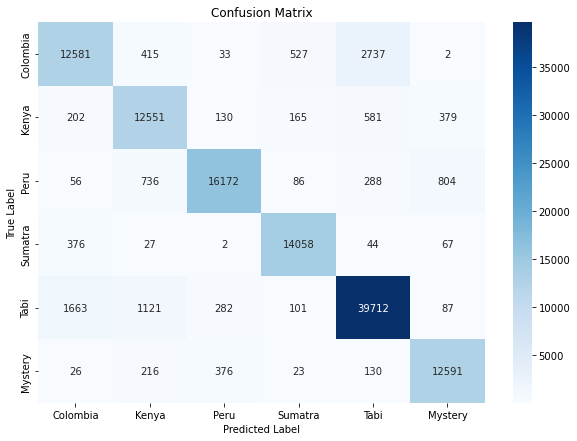

In [5]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the test set
y_pred = np.argmax(model.predict(X_test), axis=-1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Define class names based on your dataset
class_names = ['Colombia', 'Kenya', 'Peru', 'Sumatra', 'Tabi', 'Mystery']

# Plot confusion matrix
plot_confusion_matrix(cm, class_names)

In [6]:
model.save("classifier_coffee_3.keras")

Model loaded
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[0 0 0 ... 0 0 0]


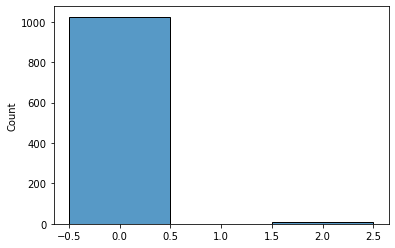

In [7]:
import numpy as np
import tensorflow as tf
from keras.models import load_model
import seaborn as sns
import h5py

dataset_path = 'session/group_0/entry_0/result/frame'

# Define preprocessing functions
def extract_tensor_from_h5(file_path, dataset_path):
    """
    Extracts a tensor from an H5 file and checks for non-numerical data.

    Parameters:
    - file_path: str, path to the H5 file
    - dataset_path: str, path to the dataset within the H5 file

    Returns:
    - tensor: numpy.ndarray, the extracted tensor if purely numerical
    """
    with h5py.File(file_path, 'r') as h5file:
        if dataset_path in h5file:
            dataset = h5file[dataset_path]
            tensor = np.array(dataset)

            return tensor
        else:
            raise KeyError(f"Dataset {dataset_path} not found in the file {file_path}")

def preprocess_data(complex_tensor):
    real_part = complex_tensor.real.astype(np.float32)
    imag_part = complex_tensor.imag.astype(np.float32)
    combined_input = np.concatenate([real_part, imag_part], axis=-1)
    return combined_input

def load_and_convert_tensor(file_path, dataset_path):
    tensor = extract_tensor_from_h5(file_path, dataset_path)
    complex_tensor = tensor['real'] + 1j * tensor['imag']
    return complex_tensor

def squeeze_data(data):
    # Remove dimensions of size 1
    return np.squeeze(data, axis=1)

# Load and preprocess new data
new_data_tensor = load_and_convert_tensor("sumatra_sample.h5", dataset_path)
new_data_input = preprocess_data(new_data_tensor)
new_data_input = squeeze_data(new_data_input)

# Load the saved model
model = load_model('classifier_coffee_3.keras')
print("Model loaded")

# Make predictions
predictions = model.predict(new_data_input)
predicted_classes = np.argmax(predictions, axis=-1)

# Print predictions
sns.histplot(predicted_classes, discrete=True)
print(predicted_classes)

Model loaded
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[0 0 0 ... 0 0 0]


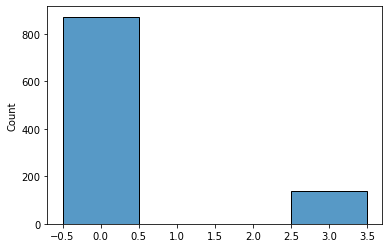

In [8]:
import numpy as np
import tensorflow as tf
from keras.models import load_model
import seaborn as sns
import h5py

dataset_path = 'session/group_0/entry_0/result/frame'

# Define preprocessing functions
def extract_tensor_from_h5(file_path, dataset_path):
    """
    Extracts a tensor from an H5 file and checks for non-numerical data.

    Parameters:
    - file_path: str, path to the H5 file
    - dataset_path: str, path to the dataset within the H5 file

    Returns:
    - tensor: numpy.ndarray, the extracted tensor if purely numerical
    """
    with h5py.File(file_path, 'r') as h5file:
        if dataset_path in h5file:
            dataset = h5file[dataset_path]
            tensor = np.array(dataset)

            return tensor
        else:
            raise KeyError(f"Dataset {dataset_path} not found in the file {file_path}")

def preprocess_data(complex_tensor):
    real_part = complex_tensor.real.astype(np.float32)
    imag_part = complex_tensor.imag.astype(np.float32)
    combined_input = np.concatenate([real_part, imag_part], axis=-1)
    return combined_input

def load_and_convert_tensor(file_path, dataset_path):
    tensor = extract_tensor_from_h5(file_path, dataset_path)
    complex_tensor = tensor['real'] + 1j * tensor['imag']
    return complex_tensor

def squeeze_data(data):
    # Remove dimensions of size 1
    return np.squeeze(data, axis=1)

# Load and preprocess new data
new_data_tensor = load_and_convert_tensor("peru_sample.h5", dataset_path)
new_data_input = preprocess_data(new_data_tensor)
new_data_input = squeeze_data(new_data_input)

# Load the saved model
model = load_model('classifier_coffee_3.keras')
print("Model loaded")

# Make predictions
predictions = model.predict(new_data_input)
predicted_classes = np.argmax(predictions, axis=-1)

# Print predictions
sns.histplot(predicted_classes, discrete=True)
print(predicted_classes)

Model loaded
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[0 0 0 ... 0 0 0]


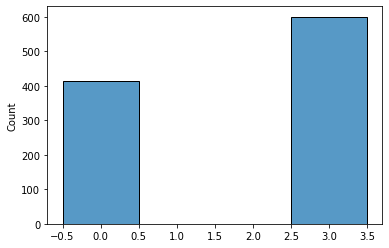

In [9]:
import numpy as np
import tensorflow as tf
from keras.models import load_model
import seaborn as sns
import h5py

dataset_path = 'session/group_0/entry_0/result/frame'

# Define preprocessing functions
def extract_tensor_from_h5(file_path, dataset_path):
    """
    Extracts a tensor from an H5 file and checks for non-numerical data.

    Parameters:
    - file_path: str, path to the H5 file
    - dataset_path: str, path to the dataset within the H5 file

    Returns:
    - tensor: numpy.ndarray, the extracted tensor if purely numerical
    """
    with h5py.File(file_path, 'r') as h5file:
        if dataset_path in h5file:
            dataset = h5file[dataset_path]
            tensor = np.array(dataset)

            return tensor
        else:
            raise KeyError(f"Dataset {dataset_path} not found in the file {file_path}")

def preprocess_data(complex_tensor):
    real_part = complex_tensor.real.astype(np.float32)
    imag_part = complex_tensor.imag.astype(np.float32)
    combined_input = np.concatenate([real_part, imag_part], axis=-1)
    return combined_input

def load_and_convert_tensor(file_path, dataset_path):
    tensor = extract_tensor_from_h5(file_path, dataset_path)
    complex_tensor = tensor['real'] + 1j * tensor['imag']
    return complex_tensor

def squeeze_data(data):
    # Remove dimensions of size 1
    return np.squeeze(data, axis=1)

# Load and preprocess new data
new_data_tensor = load_and_convert_tensor("colombia_sample.h5", dataset_path)
new_data_input = preprocess_data(new_data_tensor)
new_data_input = squeeze_data(new_data_input)

# Load the saved model
model = load_model('classifier_coffee_3.keras')
print("Model loaded")

# Make predictions
predictions = model.predict(new_data_input)
predicted_classes = np.argmax(predictions, axis=-1)

# Print predictions
sns.histplot(predicted_classes, discrete=True)
print(predicted_classes)